# Gensim word2vec 말고 keras로 직접 모델 구축하는 것!

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tqdm.notebook import tqdm_notebook
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from sklearn.datasets import fetch_20newsgroups
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
documents = dataset.data
print('총 샘플 수 :',len(documents))

총 샘플 수 : 11314


In [ ]:
print(documents[:5])

["Well i'm not sure about the story nad it did seem biased. What\nI disagree with is your statement that the U.S. Media is out to\nruin Israels reputation. That is rediculous. The U.S. media is\nthe most pro-israeli media in the world. Having lived in Europe\nI realize that incidences such as the one described in the\nletter have occured. The U.S. media as a whole seem to try to\nignore them. The U.S. is subsidizing Israels existance and the\nEuropeans are not (at least not to the same degree). So I think\nthat might be a reason they report more clearly on the\natrocities.\n\tWhat is a shame is that in Austria, daily reports of\nthe inhuman acts commited by Israeli soldiers and the blessing\nreceived from the Government makes some of the Holocaust guilt\ngo away. After all, look how the Jews are treating other races\nwhen they got power. It is unfortunate.\n", "\n\n\n\n\n\n\nYeah, do you expect people to read the FAQ, etc. and actually accept hard\natheism?  No, you need a little leap 

In [ ]:
news_df = pd.DataFrame({'document':documents})
# 특수 문자 제거
news_df['clean_doc'] = news_df['document'].str.replace("[^a-zA-Z]", " ")
# 길이가 3이하인 단어는 제거 (길이가 짧은 단어 제거)
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
# 전체 단어에 대한 소문자 변환
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: x.lower())

<ipython-input-5-b4124dfb5e6a>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  news_df['clean_doc'] = news_df['document'].str.replace("[^a-zA-Z]", " ")


In [ ]:
news_df[:5]

,document,clean_doc
0,Well i'm not sure about the story nad it did s...,well sure about story seem biased what disagre...
1,"\n\n\n\n\n\n\nYeah, do you expect people to re...",yeah expect people read actually accept hard a...
2,Although I realize that principle is not one o...,although realize that principle your strongest...
3,Notwithstanding all the legitimate fuss about ...,notwithstanding legitimate fuss about this pro...
4,"Well, I will have to change the scoring on my ...",well will have change scoring playoff pool unf...


In [ ]:
news_df.isnull().values.any()

False

빈 값 유무도 확인해서 빈 값을 Null로 변환하고 제거 진행

In [ ]:
news_df.replace("", float("NaN"), inplace=True)
news_df.isnull().values.any()

True

In [ ]:
news_df.dropna(inplace=True)
print('총 샘플 수 :',len(news_df))

총 샘플 수 : 10995


In [ ]:
!python3 -m nltk.downloader stopwords

/usr/lib/python3.8/runpy.py:127: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# 불용어를 제거
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
tokenized_doc = news_df['clean_doc'].apply(lambda x: x.split())
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])
tokenized_doc = tokenized_doc.to_list()

In [ ]:
tokenized_doc

[['well',
  'sure',
  'story',
  'seem',
  'biased',
  'disagree',
  'statement',
  'media',
  'ruin',
  'israels',
  'reputation',
  'rediculous',
  'media',
  'israeli',
  'media',
  'world',
  'lived',
  'europe',
  'realize',
  'incidences',
  'described',
  'letter',
  'occured',
  'media',
  'whole',
  'seem',
  'ignore',
  'subsidizing',
  'israels',
  'existance',
  'europeans',
  'least',
  'degree',
  'think',
  'might',
  'reason',
  'report',
  'clearly',
  'atrocities',
  'shame',
  'austria',
  'daily',
  'reports',
  'inhuman',
  'acts',
  'commited',
  'israeli',
  'soldiers',
  'blessing',
  'received',
  'government',
  'makes',
  'holocaust',
  'guilt',
  'away',
  'look',
  'jews',
  'treating',
  'races',
  'power',
  'unfortunate'],
 ['yeah',
  'expect',
  'people',
  'read',
  'actually',
  'accept',
  'hard',
  'atheism',
  'need',
  'little',
  'leap',
  'faith',
  'jimmy',
  'logic',
  'runs',
  'steam',
  'sorry',
  'pity',
  'sorry',
  'feelings',
  'denial'

In [ ]:
# # 단어가 1개 이하인 샘플의 인덱스를 찾아서 저장하고, 해당 샘플들은 제거.
# drop_train = [index for index, sentence in enumerate(tokenized_doc) if len(sentence) <= 1]
# tokenized_doc = np.delete(tokenized_doc, drop_train, axis=0)
print('총 샘플 수 :',len(tokenized_doc))

총 샘플 수 : 10940


/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


단어 집합을 생성하고, 정수 인코딩 진행

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tokenized_doc)

word2idx = tokenizer.word_index
idx2word = {value : key for key, value in word2idx.items()}
encoded = tokenizer.texts_to_sequences(tokenized_doc)

In [ ]:
idx2word

{1: 'would',
 2: 'people',
 3: 'like',
 4: 'know',
 5: 'also',
 6: 'think',
 7: 'time',
 8: 'could',
 9: 'well',
 10: 'good',
 11: 'even',
 12: 'first',
 13: 'much',
 14: 'many',
 15: 'make',
 16: 'system',
 17: 'used',
 18: 'right',
 19: 'file',
 20: 'want',
 21: 'said',
 22: 'anyone',
 23: 'need',
 24: 'work',
 25: 'something',
 26: 'problem',
 27: 'since',
 28: 'please',
 29: 'information',
 30: 'year',
 31: 'back',
 32: 'using',
 33: 'really',
 34: 'program',
 35: 'going',
 36: 'still',
 37: 'years',
 38: 'find',
 39: 'believe',
 40: 'must',
 41: 'point',
 42: 'last',
 43: 'available',
 44: 'take',
 45: 'number',
 46: 'space',
 47: 'data',
 48: 'thanks',
 49: 'things',
 50: 'windows',
 51: 'government',
 52: 'might',
 53: 'made',
 54: 'another',
 55: 'mail',
 56: 'without',
 57: 'help',
 58: 'better',
 59: 'sure',
 60: 'read',
 61: 'never',
 62: 'drive',
 63: 'part',
 64: 'long',
 65: 'case',
 66: 'look',
 67: 'however',
 68: 'power',
 69: 'question',
 70: 'world',
 71: 'name',
 72

In [ ]:
print(encoded[:2])

[[9, 59, 603, 207, 3278, 1495, 474, 702, 9470, 13686, 5533, 15227, 702, 442, 702, 70, 1148, 1095, 1036, 20294, 984, 705, 4294, 702, 217, 207, 1979, 15228, 13686, 4865, 4520, 87, 1530, 6, 52, 149, 581, 661, 4406, 4988, 4866, 1920, 755, 10668, 1102, 7837, 442, 957, 10669, 634, 51, 228, 2669, 4989, 178, 66, 222, 4521, 6066, 68, 4295], [1026, 532, 2, 60, 98, 582, 107, 800, 23, 79, 4522, 333, 7838, 864, 421, 3825, 458, 6488, 458, 2700, 4730, 333, 23, 9, 4731, 7262, 186, 310, 146, 170, 642, 1260, 107, 33568, 13, 985, 33569, 33570, 9471, 11491]]


In [ ]:
# 단어 집합의 크기 확인
vocab_size = len(word2idx) + 1 
print('단어 집합의 크기 :', vocab_size)

단어 집합의 크기 : 64277


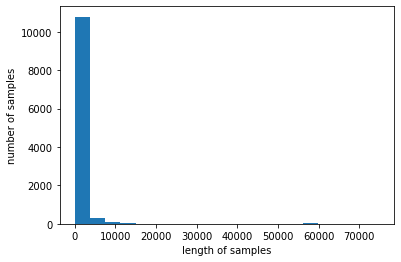

In [ ]:
# 리뷰 길이 분포 확인
import matplotlib.pyplot as plt

plt.hist([len(s) for s in list(documents)], bins=20)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

기존 word2vec 튜토리얼의 코드이고, cbow로 할지 skip-gram으로 할지 sg=0 또는 1로 선택하여 진행

In [ ]:
# from gensim.models import Word2Vec

# model = Word2Vec(sentences = tokenized_data, size = 100, window = 5, min_count = 5, workers = 4, sg = 0)

# negative sampling이 추가된 skip-gram 코드




In [ ]:
from tensorflow.keras.preprocessing.sequence import skipgrams

# 네거티브 샘플링
skip_grams = [skipgrams(sample, vocabulary_size=vocab_size, window_size=10) for sample in encoded[:10]]

In [ ]:
# 첫번째 샘플인 skip_grams[0] 내 skipgrams로 형성된 데이터셋 확인
pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(5):
    print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
          idx2word[pairs[i][0]], pairs[i][0], 
          idx2word[pairs[i][1]], pairs[i][1], 
          labels[i]))

(israeli (442), realize (1036)) -> 1
(israeli (442), world (70)) -> 1
(europeans (4520), csspab (15647)) -> 0
(media (702), reran (52726)) -> 0
(holocaust (2669), government (51)) -> 1


위에서 encoded를 10으로 설정하였기 때문에 10개의 샘플로만 진행!

In [ ]:
pairs[:20]

[[442, 1036],
 [442, 70],
 [4520, 15647],
 [702, 52726],
 [2669, 51],
 [2669, 39365],
 [702, 24015],
 [6066, 15131],
 [6066, 634],
 [13686, 1530],
 [178, 4295],
 [1102, 15106],
 [702, 61370],
 [4989, 3452],
 [13686, 38079],
 [51, 38081],
 [4865, 207],
 [6066, 10771],
 [957, 45059],
 [474, 442]]

In [ ]:
labels[:20]

[1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1]

In [ ]:
print('전체 샘플 수 :',len(skip_grams))

전체 샘플 수 : 10


In [ ]:
# 첫번째 뉴스그룹 샘플에 대해서 생긴 pairs와 labels의 개수
print(len(pairs))
print(len(labels))

2220
2220


# 이제 뉴스 그룹 샘플에 대해서만 skip-gram 파라미터 설정해서 구축

In [ ]:
skip_grams = [skipgrams(sample, vocabulary_size=vocab_size, window_size=10) for sample in encoded]

# 위의 Skip-gram에 Negative sampling 결합한 SGNS 구현

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Reshape, Activation, Input
from tensorflow.keras.layers import Dot
from tensorflow.keras.utils import plot_model
from IPython.display import SVG

In [ ]:
# 하이퍼파라미터인 임베딩 벡터의 차원은 100으로 정하고, 두 개의 임베딩 층을 추가
embedding_dim = 100

# 중심 단어를 위한 임베딩 테이블
w_inputs = Input(shape=(1, ), dtype='int32')
word_embedding = Embedding(vocab_size, embedding_dim)(w_inputs)

# 주변 단어를 위한 임베딩 테이블
c_inputs = Input(shape=(1, ), dtype='int32')
context_embedding  = Embedding(vocab_size, embedding_dim)(c_inputs)

각 임베딩 테이블은 중심 단어와 주변 단어 각각을 위한 임베딩 테이블이며 각 단어는 임베딩 테이블을 거쳐서 내적을 수행하고, 

내적의 결과는 1 또는 0을 예측하기 위해서 시그모이드 함수를 활성화 함수로 거쳐 최종 예측값을 얻음

= 소프트맥스를 통해 확률을 구하지만, 이를 이진분류하기 위해 시그모이드 적용

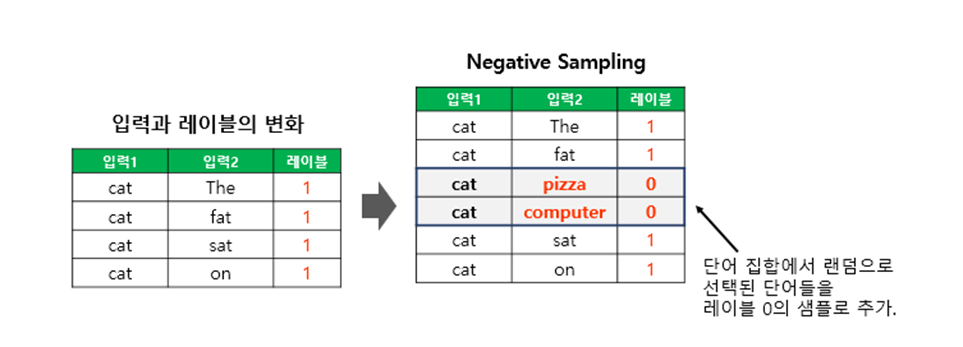

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 100)       6427700     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 100)       6427700     ['input_2[0][0]']                
                                                                                              

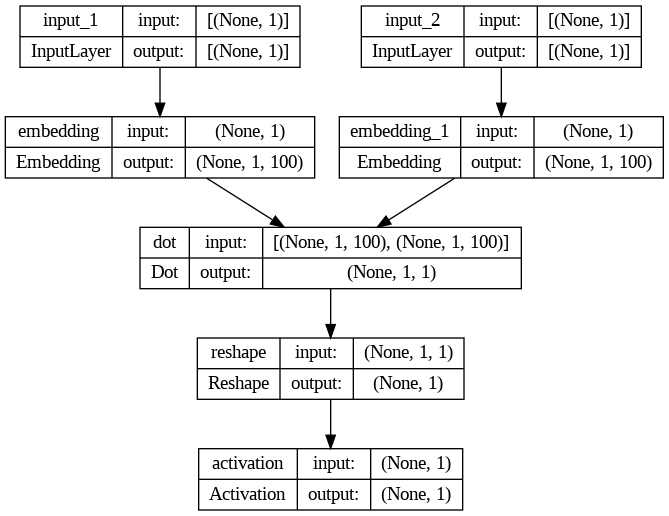

In [ ]:
dot_product = Dot(axes=2)([word_embedding, context_embedding])
dot_product = Reshape((1,), input_shape=(1, 1))(dot_product)
output = Activation('sigmoid')(dot_product)

model = Model(inputs=[w_inputs, c_inputs], outputs=output)
model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam')
plot_model(model, to_file='model3.png', show_shapes=True, show_layer_names=True, rankdir='TB')

In [ ]:
# 5에폭만 학습
for epoch in range(1, 6):
    loss = 0
    for _, elem in enumerate(skip_grams):
        first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
        second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
        labels = np.array(elem[1], dtype='int32')
        X = [first_elem, second_elem]
        Y = labels
        loss += model.train_on_batch(X,Y)  
    print('Epoch :',epoch, 'Loss :',loss)

Epoch : 1 Loss : 4626.0145313590765
Epoch : 2 Loss : 3670.3607946671546
Epoch : 3 Loss : 3511.0867908168584
Epoch : 4 Loss : 3309.2327959127724
Epoch : 5 Loss : 3084.602706900798


# 결과 확인

In [ ]:
import gensim

f = open('vectors.txt' ,'w')
f.write('{} {}\n'.format(vocab_size-1, embedding_dim))
vectors = model.get_weights()[0]
for word, i in tokenizer.word_index.items():
    f.write('{} {}\n'.format(word, ' '.join(map(str, list(vectors[i, :])))))
f.close()

# 모델 로드
w2v = gensim.models.KeyedVectors.load_word2vec_format('./vectors.txt', binary=False)

In [ ]:
w2v.most_similar(positive=['soldiers'])

[('terrorist', 0.8291085958480835),
 ('shelling', 0.820568859577179),
 ('wounded', 0.8196567296981812),
 ('territory', 0.8001712560653687),
 ('gangs', 0.7940323352813721),
 ('hamas', 0.7930158376693726),
 ('lebanese', 0.7859411239624023),
 ('gazans', 0.7791070938110352),
 ('occupying', 0.7772490382194519),
 ('arabs', 0.7769901752471924)]

In [ ]:
w2v.most_similar(positive=['doctor'])

[('kidney', 0.6237710118293762),
 ('migraine', 0.5670338869094849),
 ('stones', 0.5600777268409729),
 ('unpleasant', 0.5509212613105774),
 ('chronic', 0.5472590923309326),
 ('blood', 0.5367255210876465),
 ('analgesics', 0.5270437598228455),
 ('killers', 0.5241348147392273),
 ('medication', 0.5018959045410156),
 ('bizarre', 0.5001673698425293)]

In [ ]:
w2v.most_similar(positive=['police'])

[('officers', 0.6724660396575928),
 ('terrorist', 0.672031044960022),
 ('forces', 0.6677963733673096),
 ('bloodshed', 0.6646279692649841),
 ('inhabitants', 0.6555677652359009),
 ('headquarters', 0.6507300138473511),
 ('civilian', 0.6489346623420715),
 ('officials', 0.6443052291870117),
 ('armed', 0.641834020614624),
 ('baku', 0.6399880647659302)]

In [ ]:
w2v.most_similar(positive=['knife'])

[('lesson', 0.6879053115844727),
 ('untrue', 0.6855778694152832),
 ('violations', 0.6841700077056885),
 ('ultimate', 0.6837605237960815),
 ('nazism', 0.6815362572669983),
 ('harmed', 0.6777423620223999),
 ('idiots', 0.6775330305099487),
 ('deliberately', 0.6758822202682495),
 ('murderers', 0.675277829170227),
 ('denial', 0.6746783256530762)]

In [ ]:
w2v.most_similar(positive=['engine'])

[('sentra', 0.5372509956359863),
 ('valve', 0.5294164419174194),
 ('cars', 0.5291839838027954),
 ('miles', 0.5280784368515015),
 ('interior', 0.5262818932533264),
 ('watts', 0.5251151323318481),
 ('underpowered', 0.513952374458313),
 ('door', 0.5135149955749512),
 ('brakes', 0.5093522667884827),
 ('dual', 0.5058735013008118)]